In [7]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

from qiskit_optimization.applications import Knapsack
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

from qiskit_optimization.converters import QuadraticProgramToQubo

In [26]:
prob = Knapsack(values=[3, 4], weights=[2, 3], max_weight=10)
qp = prob.to_quadratic_program()
# intermediate QUBO form of the optimization problem
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print(qubo.prettyprint())


Problem name: Knapsack

Minimize
  8*c0@int_slack@0^2 + 32*c0@int_slack@0*c0@int_slack@1
  + 64*c0@int_slack@0*c0@int_slack@2 + 48*c0@int_slack@0*c0@int_slack@3
  + 32*c0@int_slack@1^2 + 128*c0@int_slack@1*c0@int_slack@2
  + 96*c0@int_slack@1*c0@int_slack@3 + 128*c0@int_slack@2^2
  + 192*c0@int_slack@2*c0@int_slack@3 + 72*c0@int_slack@3^2
  + 32*x_0*c0@int_slack@0 + 64*x_0*c0@int_slack@1 + 128*x_0*c0@int_slack@2
  + 96*x_0*c0@int_slack@3 + 32*x_0^2 + 96*x_0*x_1 + 48*x_1*c0@int_slack@0
  + 96*x_1*c0@int_slack@1 + 192*x_1*c0@int_slack@2 + 144*x_1*c0@int_slack@3
  + 72*x_1^2 - 160*c0@int_slack@0 - 320*c0@int_slack@1 - 640*c0@int_slack@2
  - 480*c0@int_slack@3 - 323*x_0 - 484*x_1 + 800

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 c0@int_slack@0 c0@int_slack@1 c0@int_slack@2 c0@int_slack@3



In [27]:
# qubit Hamiltonian and offset
op, offset = qubo.to_ising()
print(f"num qubits: {op.num_qubits}, offset: {offset}\n")
print(op)

num qubits: 6, offset: 132.5

SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[41.5+0.j, 62. +0.j, 20. +0.j, 40. +0.j, 80. +0.j, 60. +0.j, 24. +0.j,
  8. +0.j, 16. +0.j, 32. +0.j, 24. +0.j, 12. +0.j, 24. +0.j, 48. +0.j,
 36. +0.j,  8. +0.j, 16. +0.j, 12. +0.j, 32. +0.j, 24. +0.j, 48. +0.j])


In [28]:
from qiskit.quantum_info import SparsePauliOp

num_wires = op.num_qubits
wires = list(range(num_wires))
# H_matrix = qubitOp.to_matrix()




In [29]:

np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = op

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian

E_min = min(qml.eigvals(H))

# eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
# eigenvalues

In [52]:
dev = qml.device("default.qubit", wires=num_wires, shots=1000)  # Adjust shots as needed
import jax
import jax.numpy as jnp

# Define the ansatz (variational circuit)
def ansatz(params, wires):
    for i in range(num_wires):
        qml.RX(params[i], wires=wires[i])
    for i in range(num_wires - 1):
        qml.CNOT(wires=[wires[i], wires[i+1]])
    for i in range(num_wires):
        qml.RY(params[num_wires + i], wires=wires[i])

# Define the VQE cost function
@qml.qnode(dev, interface="jax")
def qnode(params, operation=None):
    ansatz(params, wires=list(range(num_wires)))
    return qml.expval(H)  # Expectation value of the Hamiltonian

# Optimization settings
learning_rate = 5e-4
num_steps = 500
init_params = np.random.uniform(low=0, high=2 * jnp.pi, size=(2 * num_wires,))  # Random initial params

# JIT compilation for faster computation
grad_fn = jax.jit(jax.grad(qnode))  # Gradient function
qnode = jax.jit(qnode)  # JIT-compiled qnode

# Optimization loop
def optimize(ansatz):
    params = init_params
    energies = []

    for step in range(num_steps):
        cost = qnode(params)
        grads = grad_fn(params)
        params = params - learning_rate * grads
        energies.append(cost)
    print(f"Step {step + 1}, Energy: {cost:.6f}")

    return params, energies

# Run the optimization
optimal_params, energy_history = optimize(ansatz)

print("Final optimized parameters:", optimal_params)
print("Minimum energy achieved:", energy_history[-1])

Step 500, Energy: -133.910004
Final optimized parameters: [3.1377313  6.218732   3.1101482  3.665744   5.1965895  3.4473636
 6.2871346  6.275904   0.0706436  3.3573072  0.23206562 6.252563  ]
Minimum energy achieved: -133.91


In [ ]:
# Measure the final state with optimized parameters
@qml.qnode(dev, interface="jax")
def final_state(params):
    ansatz(params, wires=list(range(num_wires)))
    return [qml.sample(qml.PauliZ(i)) for i in range(num_wires)]  # Measure each qubit in the Z-basis

# Get the measurement result for the optimal parameters
qubit_states = final_state(optimal_params)
# print("Final qubit states:", qubit_states)
nqs = np.array(qubit_states)
nqs[nqs == -1] = 0
nqs


In [97]:
qubit_states_np = nqs

# Take the most common measurement outcome (either -1 or 1) for each qubit
final_qubit_states = [np.bincount(qubit_states_np[i]).argmax() for i in range(len(qubit_states_np))]

print("Final qubit states after majority vote:", final_qubit_states)

Final qubit states after majority vote: [0, 0, 1, 1, 0, 1]


In [30]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_18196\391022573.py:24: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [38]:
loc = 2
d = loc**4 - 1  # d = 15 for two-qubit operations
dev = qml.device("default.qubit", wires=num_wires)
# two blocks with two layers. Each layer contains three operations with d parameters
param_shape = (2, 2, 3, d)
# Use np.random.uniform to initialize the parameters randomly within a range [0, 1]
init_params = np.random.uniform(low=0.0, high=2 * np.pi, size=param_shape)

def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                operation(params_op, wires_op)
    return qml.expval(H)


qnode = qml.QNode(circuit, dev, interface="jax")
print(qml.draw(qnode)(init_params, qml.SpecialUnitary))

0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M5)─╭SpecialUnitary(M6)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M3)─│───────────────────╰SpecialUnitary(M6)
2: ─╭SpecialUnitary(M1)─╰SpecialUnitary(M3)─│───────────────────╭SpecialUnitary(M7)
3: ─╰SpecialUnitary(M1)─╭SpecialUnitary(M4)─│───────────────────╰SpecialUnitary(M7)
4: ─╭SpecialUnitary(M2)─╰SpecialUnitary(M4)─│───────────────────╭SpecialUnitary(M8)
5: ─╰SpecialUnitary(M2)─────────────────────╰SpecialUnitary(M5)─╰SpecialUnitary(M8)

───────────────────────╭SpecialUnitary(M11)─┤ ╭<𝓗(M12)>
──╭SpecialUnitary(M9)──│────────────────────┤ ├<𝓗(M12)>
──╰SpecialUnitary(M9)──│────────────────────┤ ├<𝓗(M12)>
──╭SpecialUnitary(M10)─│────────────────────┤ ├<𝓗(M12)>
──╰SpecialUnitary(M10)─│────────────────────┤ ├<𝓗(M12)>
───────────────────────╰SpecialUnitary(M11)─┤ ╰<𝓗(M12)>

M0 = 
[3.90647795 1.89025592 5.17455679 6.01422213 2.0550742  3.54383787
 3.20896622 2.33048616 3.06494283 2.5650305  0.85267584 0.835979
 3.13101926 2.677422

In [42]:
# for auto-differentiation.

learning_rate = 5e-4
num_steps = 100
init_params = jax.numpy.array(init_params)
grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)
qnode = jax.jit(qnode, static_argnums=1)

In [43]:
energies = {}
eigenstates = {}  # To store the final eigenstates for each operation

for (name, print_name), operation in operations.items():
    print(f"Running the optimization for the {print_name}")
    params = init_params.copy()
    energy = []
    for step in range(num_steps):
        cost = qnode(params, operation)
        params = params - learning_rate * grad_fn(params, operation)
        energy.append(cost)  # Store energy value
        if step % 50 == 0:  # Report current energy
            print(f"{step:3d} Steps: {cost:.6f}")

    energy.append(qnode(params, operation))  # Final energy value
    energies[name] = energy

    # Extract the final eigenstate after optimization
    # At this point, `params` should contain the optimized parameters
    optimized_state = qnode(params, operation)  # This should return the final quantum state
    
    # Store the final eigenstate
    eigenstates[name] = optimized_state

# Optionally, print the final eigenstates for each operation
for name, eigenstate in eigenstates.items():
    print(f"Final eigenstate for {name}: {eigenstate}")

Running the optimization for the decomposition
  0 Steps: 8.715871
 50 Steps: -110.034348
Running the optimization for the PauliRot sequence
  0 Steps: -33.717258
 50 Steps: -110.873528
Running the optimization for the SU(N) gate


c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  0 Steps: -14.310249
 50 Steps: -109.868523
Final eigenstate for Decomposition: -120.52195739746094
Final eigenstate for PauliRot sequence: -122.3922348022461
Final eigenstate for $\mathrm{SU}(N)$ gate: -115.8885726928711


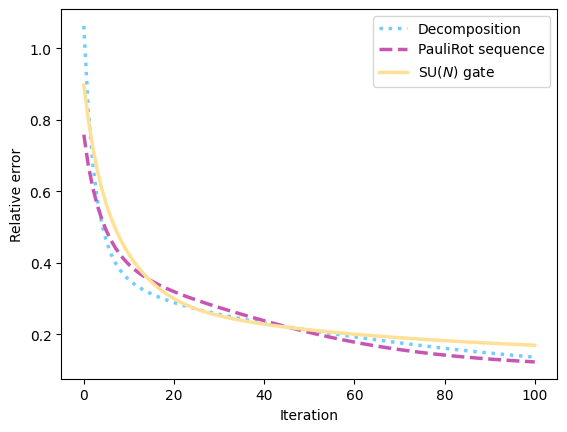

In [44]:
fig, ax = plt.subplots(1, 1)
styles = [":", "--", "-"]
colors = ["#70CEFF", "#C756B2", "#FFE096"]
for (name, energy), c, ls in zip(energies.items(), colors, styles):
    error = (energy - E_min) / abs(E_min)
    ax.plot(list(range(len(error))), error, label=name, c=c, ls=ls, lw=2.5)

ax.set(xlabel="Iteration", ylabel="Relative error")
ax.legend()
plt.show()

In [ ]:
TwoLocal